# Tutorial for continuous treatment

author: [Judith Abécassis](https://judithabk6.github.io/)

The objective of this notebook is to present two libraries for causal inference with continuous treatments. 
- [EconML](https://econml.azurewebsites.net/), that includes many estimators, and in particular Causal forests, and Double Machine learning estimators. An example of analysis of treatment heterogeneity can be found [here](https://github.com/py-why/EconML/blob/main/notebooks/Double%20Machine%20Learning%20Examples.ipynb) and [here](https://cpb-us-w2.wpmucdn.com/sites.coecis.cornell.edu/dist/a/238/files/2019/12/Id_112_final.pdf)
- [CausalCurve](https://github.com/ronikobrosly/causal-curve) that implements the classical Generalized Propensity Score approach (refs include [Imbens paper](https://www.math.mcgill.ca/dstephens/PSMMA/Articles/HIrano-Imbens-2004.pdf), [Kosuke paper](https://imai.fas.harvard.edu/research/files/pscore.pdf), [slides by Fan Li](https://www2.stat.duke.edu/~fl35/teaching/640/Chap3.6_Non-Binary%20Treatment.pdf)) and non-parametric approaches based on [Kennedy's paper](https://academic.oup.com/jrsssb/article/79/4/1229/7040663) with some R code in the supplementary.

To start, I suggest reading the Kennedy's paper first.

From what I understand, DML has the hypothesis that the treatment effect is linear, which is not always true. You can actually change that by featurizing the treatment and include polynomial or spline features, as said in the [DMLFAQ](https://econml.azurewebsites.net/spec/estimation/dml.html#dmluserguide). However you can very nicely explore treatment effect heterogeneity. In CausalCurve, you don't have a linear treatment effect, but not really suited to explore treatment effect heterogeneity.

Application to two datasets is presented here. More information on the datasets can be found in the `data` folder. 


Some preliminary remarks (this is not a full benchmark of both libraries, and I have not yet fully reviewed the theoretical details of all methods):
- linear approaches seem to return biased estimates in DML for both datasets (no heterogeneity in the age of starting smoking for the first datasets, and wrong direction of the treatment effect variation with income in the second dataset)
- TMLE in CausalCurve is very long to run...

Some things to do
- further explore implemented methods in EconML to see if there are other approaches that allow non-linear treatment effect (I have checked a lot of methods, but not all yet), besides this feature engineering of the treatment
- understand how the generalized propensity score is estimated, and if there is room for improvement
- understand the TMLE implementation
- have some simulations to better evaluate everything (maybe with the scheme of Kennedy's paper)
- differences in the R implementation from Kennedy's paper and CausalCurve
- see how to adapt CausalCurve to treatment heterogeneity

In [1]:
import pandas as pd
import numpy as np


from econml.dml import DML, NonParamDML
from econml.orf import DMLOrthoForest, DROrthoForest
from econml.sklearn_extensions.linear_model import WeightedLassoCVWrapper, WeightedLasso, WeightedLassoCV


from causal_curve import GPS_Regressor
from causal_curve import TMLE_Regressor

from sklearn.linear_model import Lasso, LassoCV, RidgeCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier


import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_columns = None
alphas = np.logspace(-7, 2, 10)

/var/folders/yq/y5_9g35d04x73tsld77tmd7r0000gn/T/ipykernel_81042/941690824.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


## Packyears data
### Data preparation and exploration

In [2]:
df = pd.read_csv('../data/nmes_data.csv')
df.head()

,packyears,AGESMOKE,LASTAGE,MALE,RACE3,beltuse,educate,marital,SREGION,POVSTALB,HSQACCWT,TOTALEXP
0,15.0,15,29,0,3,3,1,1,1,3,10606.537,284.00
1,11.7,16,28,1,3,2,1,1,1,3,11499.838,176.60
2,30.0,21,80,1,3,1,1,3,1,3,9511.536,1368.76
3,9.0,30,60,0,3,3,1,5,1,5,13040.139,795.00
4,2.0,16,82,0,3,3,1,5,1,4,9817.293,1627.09


In [3]:
df.describe(include='all')

,packyears,AGESMOKE,LASTAGE,MALE,RACE3,beltuse,educate,marital,SREGION,POVSTALB,HSQACCWT,TOTALEXP
count,9708.000000,9708.000000,9708.000000,9708.000000,9708.000000,9708.000000,9708.000000,9708.000000,9708.000000,9708.000000,9708.000000,9708.000000
mean,24.480619,18.389576,47.097960,0.515863,2.715492,2.237639,2.513700,1.956119,2.513700,3.794293,8072.243594,2042.007889
std,24.297115,5.243279,17.245719,0.499774,0.577932,0.848269,1.023429,1.458089,1.023429,1.272018,3776.721044,6410.794544
min,0.050000,9.000000,19.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,908.021000,0.000000
25%,6.600000,16.000000,32.000000,0.000000,3.000000,1.000000,2.000000,1.000000,2.000000,3.000000,4975.330000,90.000000
50%,17.250000,18.000000,45.000000,1.000000,3.000000,3.000000,3.000000,1.000000,3.000000,4.000000,7074.542000,406.090000
75%,34.500000,20.000000,62.000000,1.000000,3.000000,3.000000,3.000000,3.000000,3.000000,5.000000,10980.077500,1350.327500
max,216.000000,70.000000,94.000000,1.000000,3.000000,3.000000,4.000000,5.000000,4.000000,5.000000,35171.531000,175095.970000


In [4]:
df_filter = df[df["TOTALEXP"]>0]
print(len(df_filter), len(df))

8263 9708


In [5]:
df_filter = df_filter.assign(log_TOTALEXP = np.log(df_filter.TOTALEXP))
df_filter = df_filter.drop('TOTALEXP', axis=1)
outcome = 'log_TOTALEXP'
treatment = 'packyears'
covariates = set(df.columns).difference([treatment, outcome])
categorical_variables = ['RACE3', 'beltuse', 'educate', 'marital', 'SREGION', 'POVSTALB']

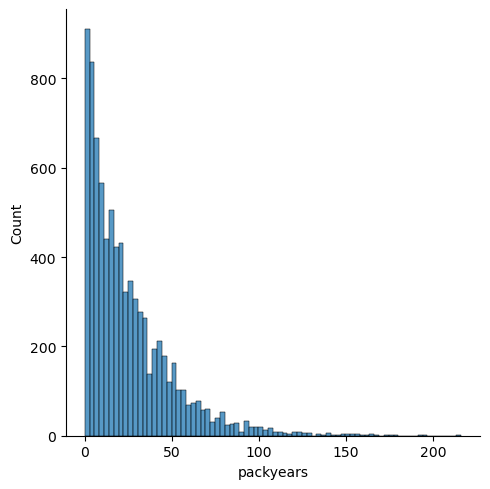

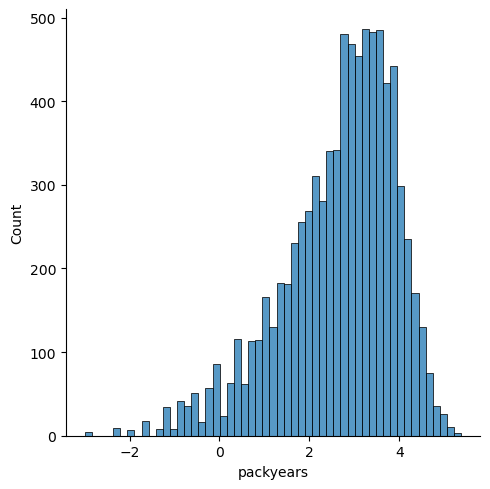

In [6]:
sns.displot(df_filter[treatment])
sns.displot(np.log(df_filter[treatment]))

In [7]:
df_filter = df_filter.assign(log_packyears = np.log(df_filter.packyears))
df_filter = df_filter.drop('packyears', axis=1)

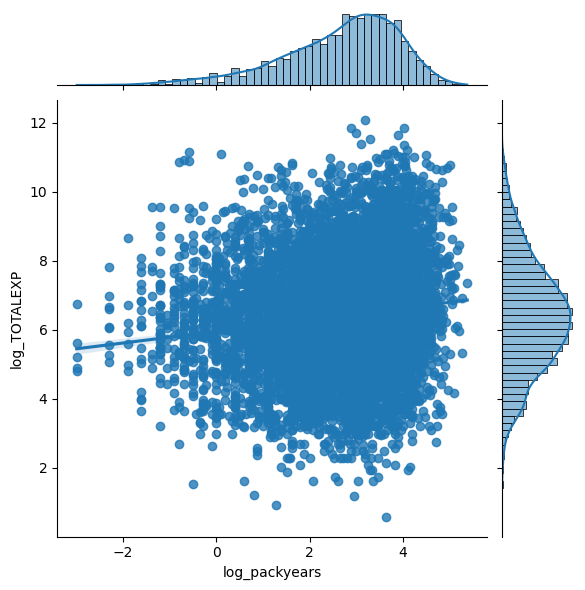

In [8]:
sns.jointplot(data=df_filter, x='log_packyears', y="log_TOTALEXP", kind='reg')

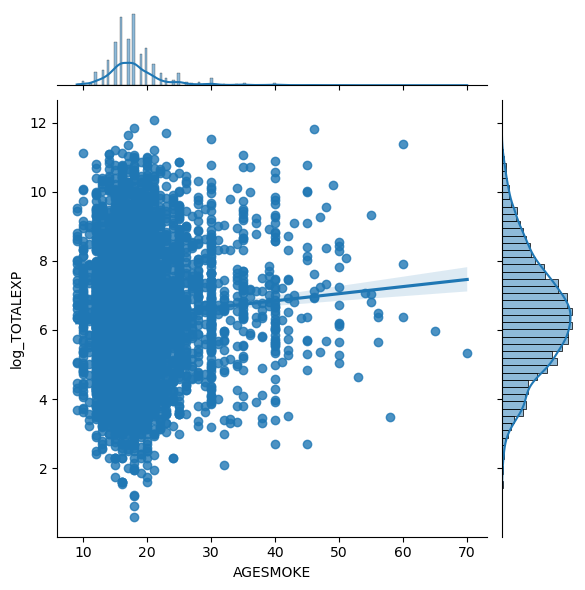

In [9]:
sns.jointplot(data=df_filter, x='AGESMOKE', y="log_TOTALEXP", kind='reg')

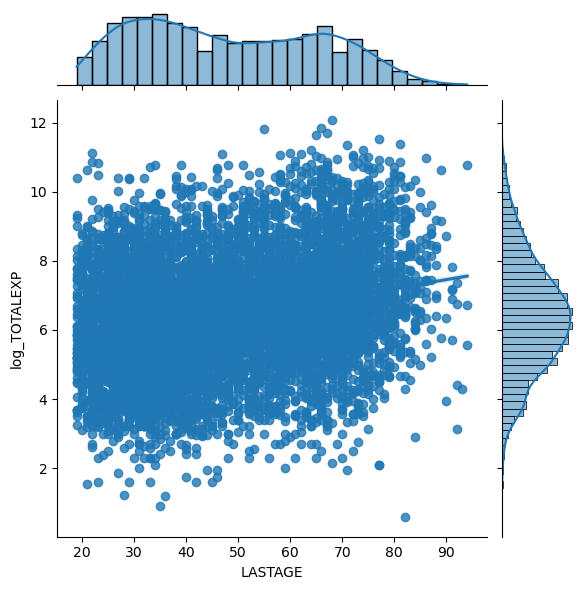

In [10]:
sns.jointplot(data=df_filter, x='LASTAGE', y="log_TOTALEXP", kind='reg')

SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.


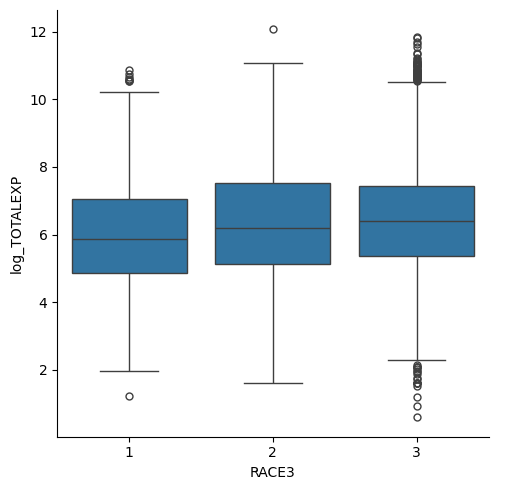

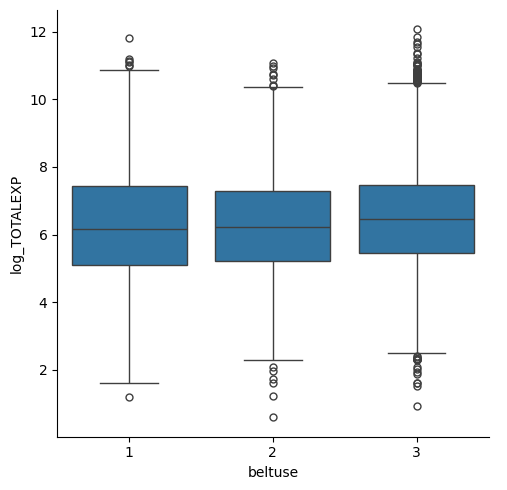

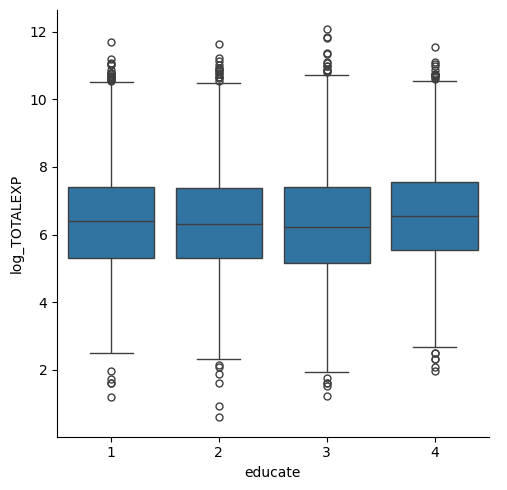

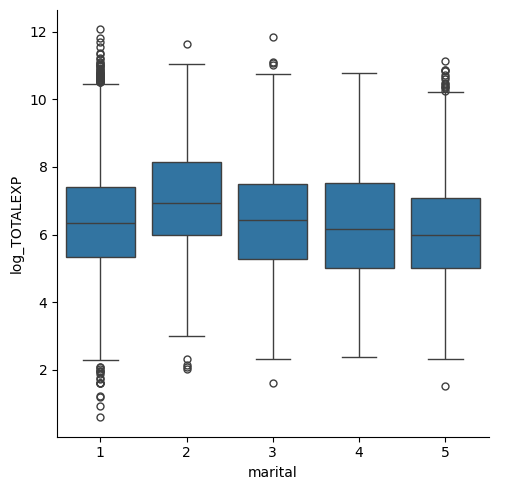

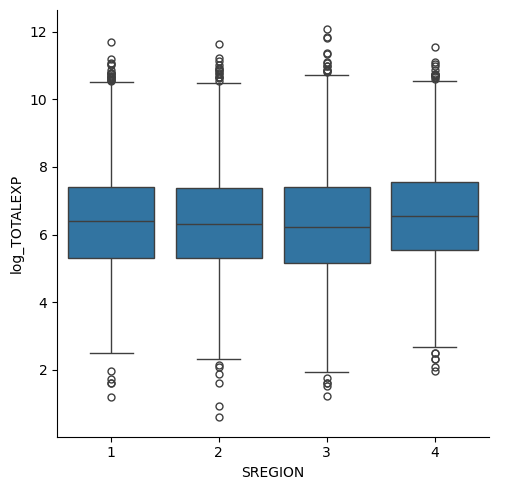

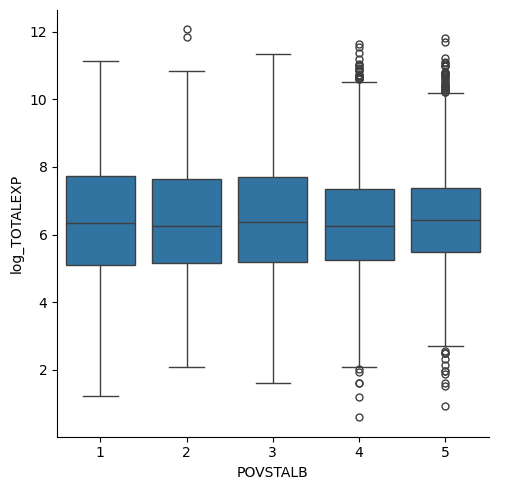

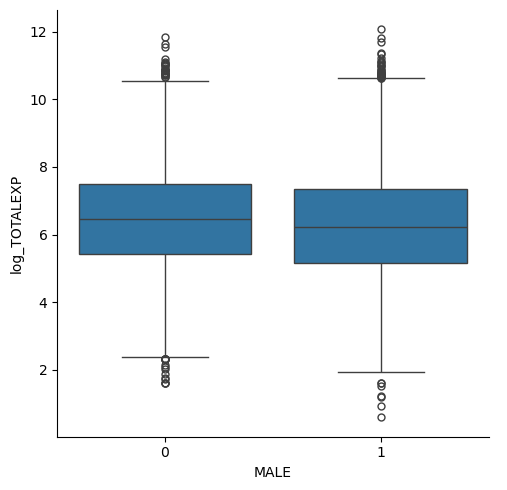

In [11]:
for cov in categorical_variables + ['MALE']:
    sns.catplot(y=outcome, x=cov, data=df_filter, kind='box')

In [12]:

df_filter = df_filter.drop('HSQACCWT', axis=1)
df_filter = pd.get_dummies(df_filter, columns=categorical_variables, drop_first=True).astype(float)
df_filter.describe(include='all')

,AGESMOKE,LASTAGE,MALE,log_TOTALEXP,log_packyears,RACE3_2,RACE3_3,beltuse_2,beltuse_3,educate_2,educate_3,educate_4,marital_2,marital_3,marital_4,marital_5,SREGION_2,SREGION_3,SREGION_4,POVSTALB_2,POVSTALB_3,POVSTALB_4,POVSTALB_5
count,8263.000000,8263.000000,8263.000000,8263.000000,8263.000000,8263.000000,8263.000000,8263.000000,8263.000000,8263.000000,8263.000000,8263.00000,8263.000000,8263.000000,8263.000000,8263.000000,8263.000000,8263.000000,8263.00000,8263.000000,8263.000000,8263.000000,8263.000000
mean,18.477430,48.138570,0.486506,6.401379,2.646164,0.138691,0.803703,0.220743,0.522449,0.257049,0.336682,0.19073,0.082295,0.109282,0.034007,0.124894,0.257049,0.336682,0.19073,0.047077,0.142079,0.333293,0.375529
std,5.334803,17.424431,0.499848,1.626753,1.264265,0.345644,0.397220,0.414773,0.499526,0.437033,0.472604,0.39290,0.274830,0.312012,0.181258,0.330619,0.437033,0.472604,0.39290,0.211817,0.349152,0.471419,0.484289
min,9.000000,19.000000,0.000000,0.587787,-2.995732,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,16.000000,33.000000,0.000000,5.298317,1.945910,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
50%,18.000000,46.000000,0.000000,6.361302,2.890372,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
75%,20.000000,63.000000,1.000000,7.432407,3.556775,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.00000,0.000000,0.000000,1.000000,1.000000
max,70.000000,94.000000,1.000000,12.073090,5.375278,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000


In [13]:
treatment = 'log_packyears'
outcome = 'log_TOTALEXP'
covariates = set(df_filter.columns).difference([treatment, outcome])

We should remove data with no medical expenses ("missing" data, I think dead people actually). Might bias the analysis but better than doing nothing in that case... Also, predicting the log of the expenses seems like a good idea.

### EconML linear model

In [14]:
est = DML(model_y=make_pipeline(StandardScaler(), RidgeCV(alphas=alphas, cv=3)),
          model_t=make_pipeline(StandardScaler(), RidgeCV(alphas=alphas, cv=3)),
          model_final=make_pipeline(StandardScaler(), RidgeCV(alphas=alphas, cv=3)))
est.fit(df_filter[outcome].values, df_filter[treatment].values, X=df_filter[sorted(list(covariates))].values, inference='bootstrap')

In [15]:
est.effect(X=df_filter[sorted(list(covariates))].values, T0=-1, T1=4)

array([ 0.10362508,  0.65629251,  0.29931583, ..., -0.03049834,
       -0.27373793, -0.05195   ])

In [16]:
tau = [est.ate(X=df_filter[sorted(list(covariates))].values, T0=-1, T1=i) for i in np.linspace(-1, 4, 50)]

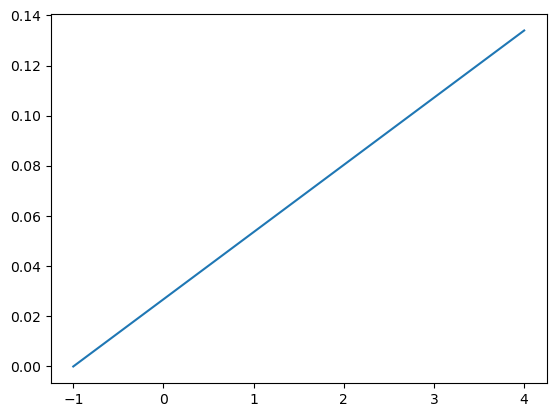

In [17]:
plt.plot(np.linspace(-1, 4, 50), tau)

In [18]:
sorted(list(covariates))

['AGESMOKE',
 'LASTAGE',
 'MALE',
 'POVSTALB_2',
 'POVSTALB_3',
 'POVSTALB_4',
 'POVSTALB_5',
 'RACE3_2',
 'RACE3_3',
 'SREGION_2',
 'SREGION_3',
 'SREGION_4',
 'beltuse_2',
 'beltuse_3',
 'educate_2',
 'educate_3',
 'educate_4',
 'marital_2',
 'marital_3',
 'marital_4',
 'marital_5']

In [19]:
## gender effect
x_male = np.array([20, 50, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0])
x_female = np.array([20, 50, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0])
treatment_effects_male = est.const_marginal_effect(x_male.reshape(1, -1))
treatment_effects_female = est.const_marginal_effect(x_female.reshape(1, -1))
print(treatment_effects_male, treatment_effects_female)

[0.13034145] [0.07061458]


Text(0, 0.5, 'treatment effect')

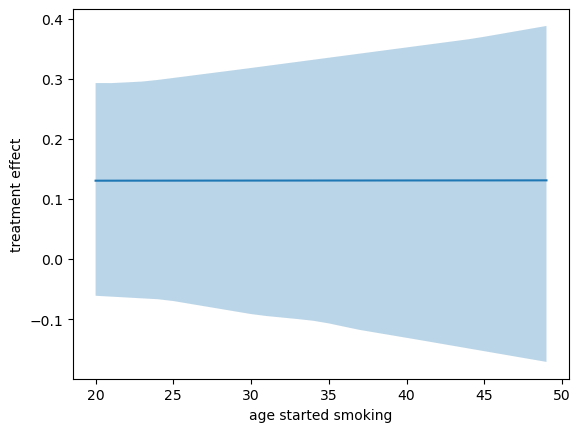

In [20]:
x_smokeage = np.array([[i, 50, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0] for i in range(20, 50)])
treatment_effects_smokeage = est.const_marginal_effect(x_smokeage)
te_lower, te_upper = est.const_marginal_effect_interval(x_smokeage)
plt.plot(x_smokeage[:, 0], treatment_effects_smokeage)
plt.fill_between(x_smokeage[:, 0], te_lower, te_upper, alpha=0.3)
plt.xlabel('age started smoking')
plt.ylabel('treatment effect')

Text(0, 0.5, 'treatment effect')

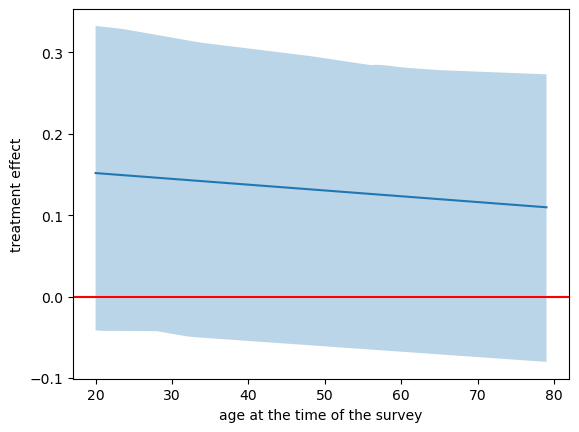

In [21]:
x_lastage = np.array([[20, i, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0] for i in range(20, 80)])
treatment_effects_lastage = est.const_marginal_effect(x_lastage)
te_lower, te_upper = est.const_marginal_effect_interval(x_lastage)
plt.plot(x_lastage[:, 1], treatment_effects_lastage)
plt.fill_between(x_lastage[:, 1], te_lower, te_upper, alpha=0.3)
plt.axhline(y=0, color='red')
plt.xlabel('age at the time of the survey')
plt.ylabel('treatment effect')

### EconML gradient boosting

In [22]:
est = NonParamDML(
    model_y=RandomForestRegressor(min_samples_leaf=20),
    model_t=RandomForestRegressor(min_samples_leaf=20),
    model_final=RandomForestRegressor(min_samples_leaf=20),
    discrete_treatment=False
)
est.fit(df_filter[outcome].values, df_filter[treatment].values, X=df_filter[sorted(list(covariates))].values, inference='bootstrap')


In [23]:
tau = [est.ate(X=df_filter[sorted(list(covariates))].values, T0=-1, T1=i) for i in np.linspace(-1, 4, 50)]

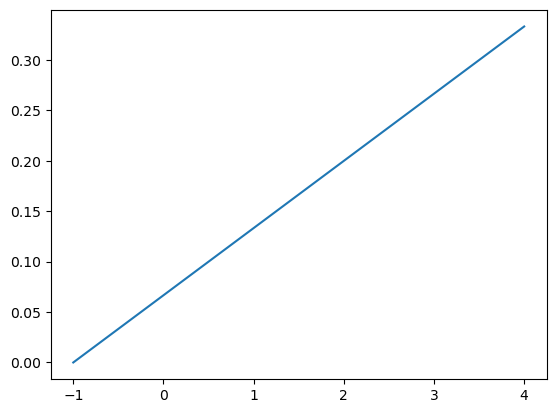

In [24]:
plt.plot(np.linspace(-1, 4, 50), tau)

In [25]:
## gender effect
x_male = np.array([20, 50, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0])
x_female = np.array([20, 50, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0])
treatment_effects_male = est.const_marginal_effect(x_male.reshape(1, -1))
treatment_effects_female = est.const_marginal_effect(x_female.reshape(1, -1))
print(treatment_effects_male, treatment_effects_female)

[0.2835364] [0.19793006]


Text(0, 0.5, 'treatment effect')

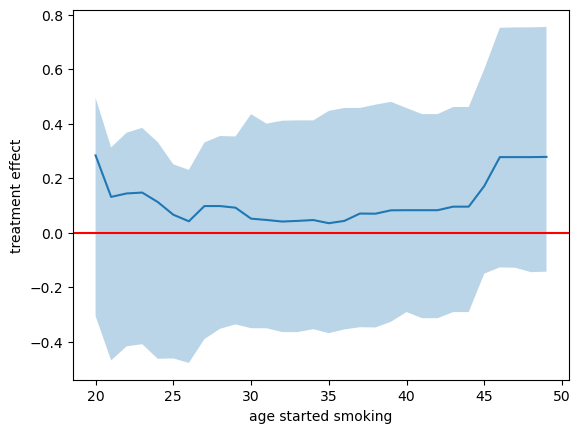

In [26]:
x_smokeage = np.array([[i, 50, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0] for i in range(20, 50)])
treatment_effects_smokeage = est.const_marginal_effect(x_smokeage)
te_lower, te_upper = est.const_marginal_effect_interval(x_smokeage)
plt.plot(x_smokeage[:, 0], treatment_effects_smokeage)
plt.fill_between(x_smokeage[:, 0], te_lower, te_upper, alpha=0.3)
plt.axhline(y=0, color='red')
plt.xlabel('age started smoking')
plt.ylabel('treatment effect')

Text(0, 0.5, 'treatment effect')

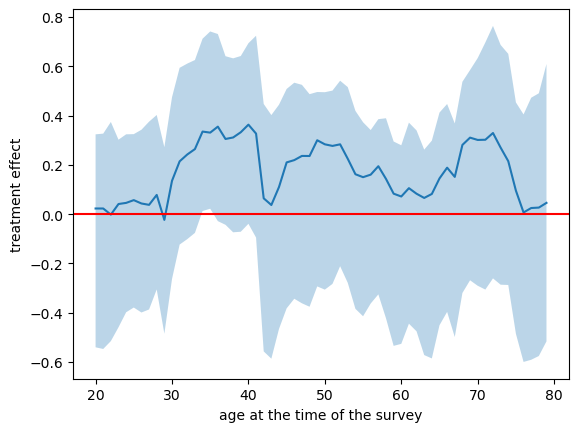

In [27]:
x_lastage = np.array([[20, i, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0] for i in range(20, 80)])
treatment_effects_lastage = est.const_marginal_effect(x_lastage)
te_lower, te_upper = est.const_marginal_effect_interval(x_lastage)
plt.plot(x_lastage[:, 1], treatment_effects_lastage)
plt.fill_between(x_lastage[:, 1], te_lower, te_upper, alpha=0.3)
plt.axhline(y=0, color='red')
plt.xlabel('age at the time of the survey')
plt.ylabel('treatment effect')

### CausalCurve Generalized Propensity Score approach

In [28]:

gps = GPS_Regressor()
gps.fit(T = df_filter[treatment], X = df_filter[sorted(list(covariates))], y = df_filter[outcome])
gps_results = gps.calculate_CDRC(0.95)

In [29]:
gps_results

,Treatment,Causal_Dose_Response,Lower_CI,Upper_CI
0,-1.050,6.496,6.056,6.937
1,-0.655,6.544,6.159,6.929
2,-0.288,6.244,5.853,6.635
3,0.000,6.431,6.055,6.808
4,0.182,6.572,6.194,6.951
...,...,...,...,...
95,4.304,7.284,6.981,7.587
96,4.366,7.328,7.010,7.647
97,4.454,7.389,7.054,7.723
98,4.564,7.450,7.107,7.793


Text(0, 0.5, 'medical expenses (log)')

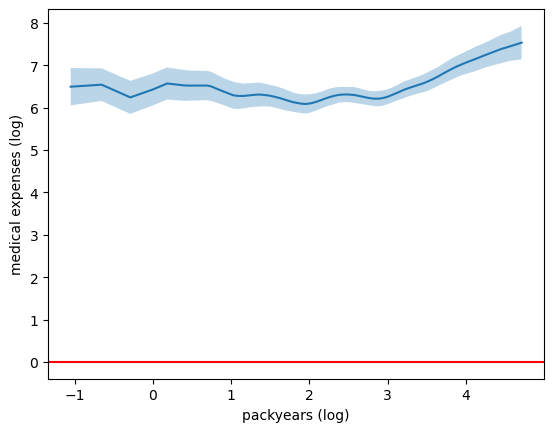

In [30]:
plt.plot(gps_results.Treatment, gps_results.Causal_Dose_Response)
plt.fill_between(gps_results.Treatment, gps_results.Lower_CI, gps_results.Upper_CI, alpha=0.3)
plt.axhline(y=0, color='red')
plt.xlabel('packyears (log)')
plt.ylabel('medical expenses (log)')

### CausalCurve TMLE approach

Text(0, 0.5, 'medical expenses (log)')

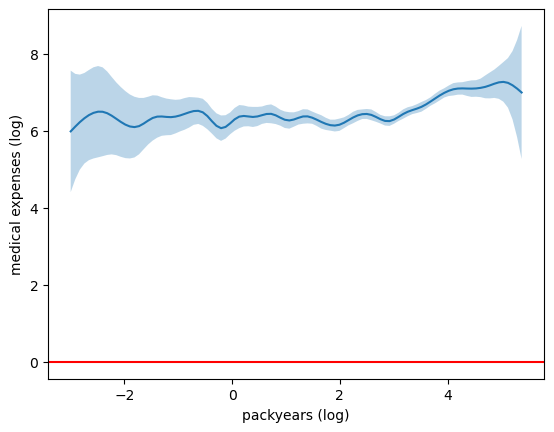

In [31]:

tmle = TMLE_Regressor()
tmle.fit(T = df_filter[treatment], X = df_filter[sorted(list(covariates))], y = df_filter[outcome])
tmle_results = tmle.calculate_CDRC(0.95)
plt.plot(tmle_results.Treatment, tmle_results.Causal_Dose_Response)
plt.fill_between(tmle_results.Treatment, tmle_results.Lower_CI, tmle_results.Upper_CI, alpha=0.3)
plt.axhline(y=0, color='red')
plt.xlabel('packyears (log)')
plt.ylabel('medical expenses (log)')

## Orange juice data
some documentation can be found [here](https://www.rdocumentation.org/packages/bayesm/versions/3.1-6/topics/orangeJuice)
### Data preparation and exploration

In [32]:
oj = pd.read_csv('../data/oj_large.csv')
oj.head()

,store,brand,week,logmove,feat,price,AGE60,EDUC,ETHNIC,INCOME,HHLARGE,WORKWOM,HVAL150,SSTRDIST,SSTRVOL,CPDIST5,CPWVOL5
0,2,tropicana,40,9.018695,0,3.87,0.232865,0.248935,0.11428,10.553205,0.103953,0.303585,0.463887,2.110122,1.142857,1.92728,0.376927
1,2,tropicana,46,8.723231,0,3.87,0.232865,0.248935,0.11428,10.553205,0.103953,0.303585,0.463887,2.110122,1.142857,1.92728,0.376927
2,2,tropicana,47,8.253228,0,3.87,0.232865,0.248935,0.11428,10.553205,0.103953,0.303585,0.463887,2.110122,1.142857,1.92728,0.376927
3,2,tropicana,48,8.987197,0,3.87,0.232865,0.248935,0.11428,10.553205,0.103953,0.303585,0.463887,2.110122,1.142857,1.92728,0.376927
4,2,tropicana,50,9.093357,0,3.87,0.232865,0.248935,0.11428,10.553205,0.103953,0.303585,0.463887,2.110122,1.142857,1.92728,0.376927


<Axes: xlabel='price', ylabel='Density'>

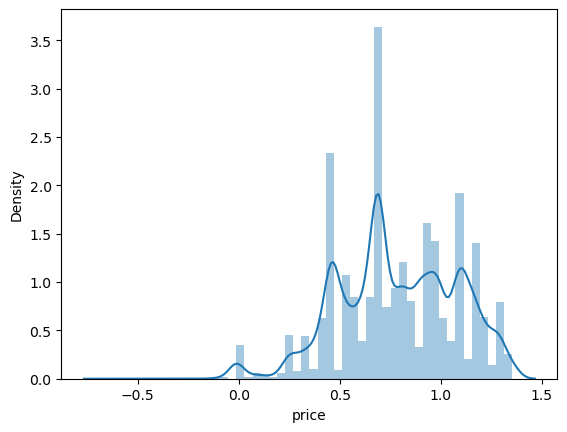

In [33]:
sns.distplot(np.log(oj.price))

<Axes: xlabel='logmove', ylabel='Density'>

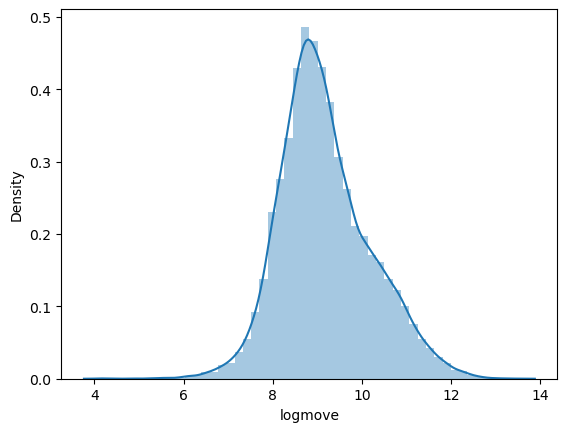

In [34]:
sns.distplot(oj.logmove)

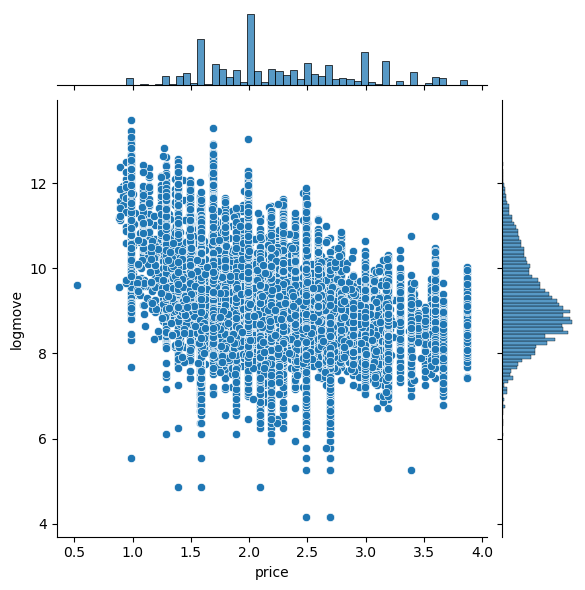

In [35]:
sns.jointplot(x='price', y='logmove', data=oj)

In [36]:
oj.describe(include='all')

,store,brand,week,logmove,feat,price,AGE60,EDUC,ETHNIC,INCOME,HHLARGE,WORKWOM,HVAL150,SSTRDIST,SSTRVOL,CPDIST5,CPWVOL5
count,28947.000000,28947,28947.000000,28947.000000,28947.000000,28947.000000,28947.000000,28947.000000,28947.000000,28947.000000,28947.000000,28947.000000,28947.000000,28947.000000,28947.000000,28947.000000,28947.000000
unique,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,tropicana,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,9649,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,80.883511,NaN,100.459944,9.167864,0.237261,2.282488,0.173130,0.225220,0.155557,10.616735,0.115602,0.359178,0.343766,5.097274,1.207317,2.120359,0.438914
std,35.576511,NaN,34.692314,1.019378,0.425411,0.648001,0.061872,0.109945,0.187581,0.282314,0.030168,0.052673,0.239028,3.472386,0.526528,0.729828,0.219248
min,2.000000,NaN,40.000000,4.158883,0.000000,0.520000,0.058054,0.049550,0.024247,9.867083,0.013506,0.244463,0.002509,0.132097,0.400000,0.772530,0.094562
25%,53.000000,NaN,70.000000,8.489616,0.000000,1.790000,0.122100,0.145985,0.041910,10.456079,0.097938,0.312636,0.123486,2.767046,0.727273,1.626192,0.271673
50%,86.000000,NaN,101.000000,9.034080,0.000000,2.170000,0.170655,0.229390,0.074656,10.635326,0.111221,0.355635,0.346154,4.650687,1.115385,1.963412,0.383227
75%,111.000000,NaN,130.000000,9.764685,0.000000,2.730000,0.213949,0.284395,0.187761,10.796960,0.135168,0.402313,0.528313,6.650602,1.538462,2.533672,0.560240


In [37]:
oj.nunique(axis=0)

store         83
brand          3
week         121
logmove     1902
feat           2
price        245
AGE60         83
EDUC          83
ETHNIC        83
INCOME        83
HHLARGE       83
WORKWOM       83
HVAL150       83
SSTRDIST      83
SSTRVOL       67
CPDIST5       83
CPWVOL5       83
dtype: int64

In [38]:
oj = pd.get_dummies(oj, columns=['brand'], drop_first=True).astype(float)

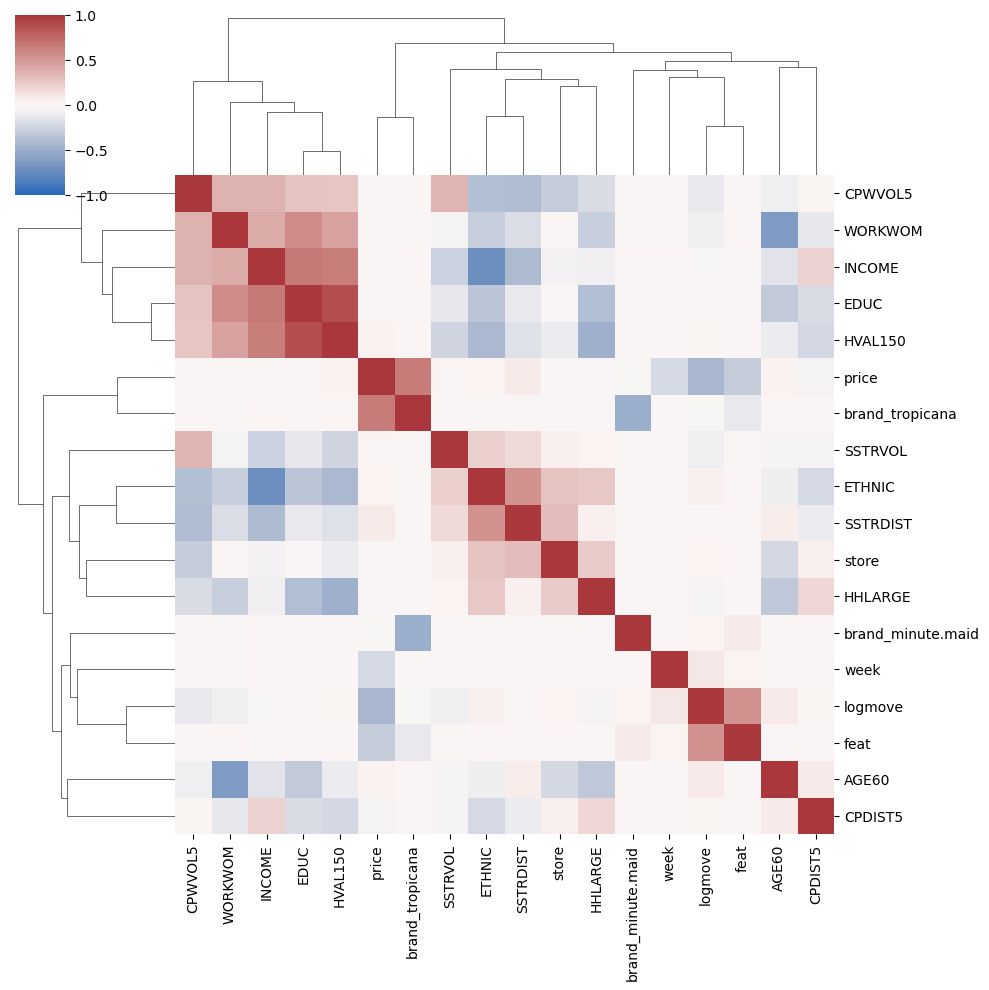

In [39]:
sns.clustermap(oj.corr(), vmin=-1, vmax=1, center=0, cmap="vlag")

In [40]:
covariates = [c for c in oj.columns if c not in ['price', 'logmove', 'week', 'store']]
treatment = 'price'
outcome = 'logmove'

### EconML linear model

In [41]:
est = DML(model_y=make_pipeline(StandardScaler(), RidgeCV(alphas=alphas, cv=3)),
          model_t=make_pipeline(StandardScaler(), RidgeCV(alphas=alphas, cv=3)),
          model_final=make_pipeline(StandardScaler(), RidgeCV(alphas=alphas, cv=3)))
est.fit(oj[outcome].values, oj[treatment].values, X=oj[sorted(list(covariates))].values, inference='bootstrap')


In [42]:
tau = [est.ate(X=oj[sorted(list(covariates))].values, T0=0.5, T1=i) for i in np.linspace(0.5, 4, 50)]

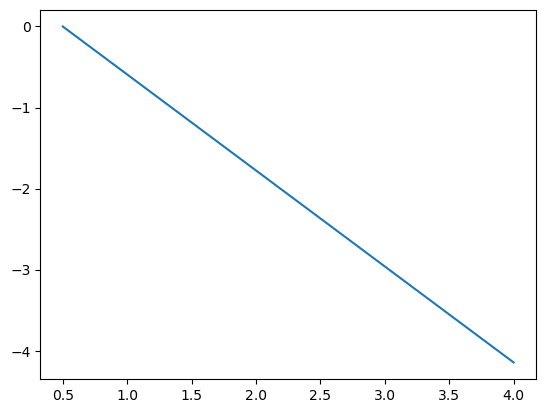

In [43]:
plt.plot(np.linspace(0.5, 4, 50), tau)

In [44]:
sorted(list(covariates))

['AGE60',
 'CPDIST5',
 'CPWVOL5',
 'EDUC',
 'ETHNIC',
 'HHLARGE',
 'HVAL150',
 'INCOME',
 'SSTRDIST',
 'SSTRVOL',
 'WORKWOM',
 'brand_minute.maid',
 'brand_tropicana',
 'feat']

Text(0, 0.5, 'treatment effect')

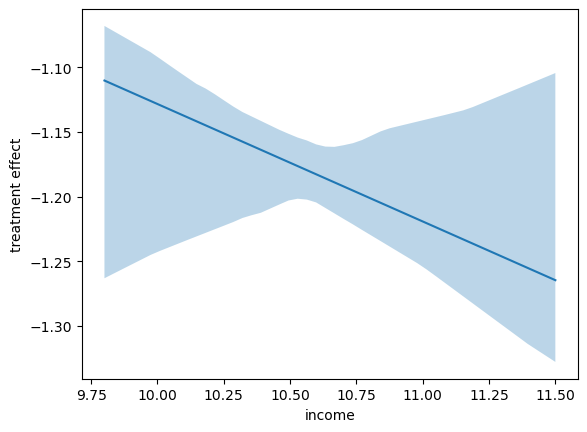

In [45]:
x_avg = oj[sorted(list(covariates))].mean().values
x_income = np.array([np.concatenate([x_avg[:7], [i], x_avg[8:]])  for i in np.linspace(9.8, 11.5, 50)])

treatment_effects_income = est.const_marginal_effect(x_income)
te_lower, te_upper = est.const_marginal_effect_interval(x_income)
plt.plot(x_income[:, 7], treatment_effects_income)
plt.fill_between(x_income[:, 7], te_lower, te_upper, alpha=0.3)
plt.xlabel('income')
plt.ylabel('treatment effect')

### EconML gradient boosting

In [46]:
est = NonParamDML(
    model_y=RandomForestRegressor(min_samples_leaf=20),
    model_t=RandomForestRegressor(min_samples_leaf=20),
    model_final=RandomForestRegressor(min_samples_leaf=20),
    discrete_treatment=False
)
est.fit(oj[outcome].values, oj[treatment].values, X=oj[sorted(list(covariates))].values, inference='bootstrap')


In [47]:
tau = [est.ate(X=oj[sorted(list(covariates))].values, T0=0.5, T1=i) for i in np.linspace(0.5, 4, 50)]

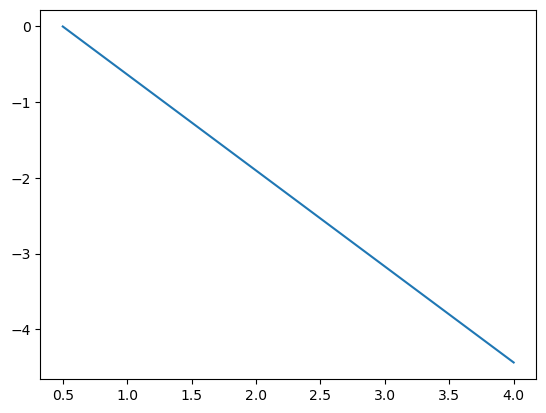

In [48]:
plt.plot(np.linspace(0.5, 4, 50), tau)

Text(0, 0.5, 'treatment effect')

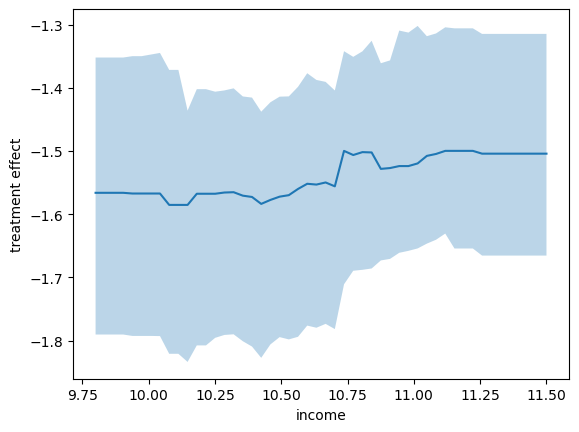

In [49]:
x_avg = oj[sorted(list(covariates))].mean().values
x_income = np.array([np.concatenate([x_avg[:7], [i], x_avg[8:]])  for i in np.linspace(9.8, 11.5, 50)])

treatment_effects_income = est.const_marginal_effect(x_income)
te_lower, te_upper = est.const_marginal_effect_interval(x_income)
plt.plot(x_income[:, 7], treatment_effects_income)
plt.fill_between(x_income[:, 7], te_lower, te_upper, alpha=0.3)
plt.xlabel('income')
plt.ylabel('treatment effect')

### EconML Orthogonal Forest

In [52]:
# Define some parameters
n_trees = 1000
min_leaf_size = 50
max_depth = 20
subsample_ratio = 0.04
lambda_reg = np.sqrt(np.log(len(covariates)) / (10 * subsample_ratio * 5000))

sub_oj = oj.sample(5000, random_state=0)

In [53]:
est = DMLOrthoForest(
        n_trees=n_trees, min_leaf_size=min_leaf_size, max_depth=max_depth, 
        subsample_ratio=subsample_ratio,
    model_T=Lasso(alpha=lambda_reg),
    model_Y=Lasso(alpha=lambda_reg),
    model_T_final=WeightedLasso(alpha=lambda_reg),
    model_Y_final=WeightedLasso(alpha=lambda_reg)
       )

In [54]:
est.fit(sub_oj[outcome].values, sub_oj[treatment].values, X=sub_oj[sorted(list(covariates))].values, inference='bootstrap')


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 344 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   12.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 824 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 127 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   17.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 208 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    7.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 208 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    5.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 208 tasks      | elap

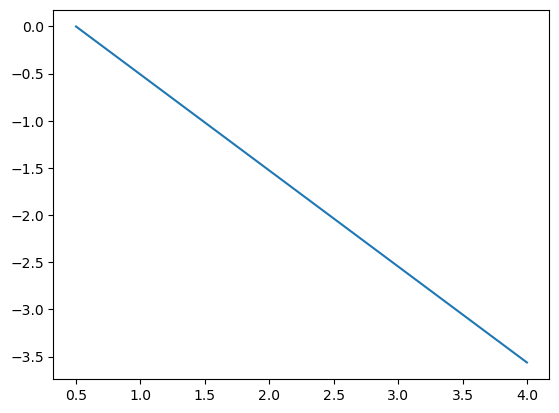

In [56]:
tau = [est.ate(X=oj.sample(500, random_state=9)[sorted(list(covariates))].values, T0=0.5, T1=i) for i in np.linspace(0.5, 4, 50)]
plt.plot(np.linspace(0.5, 4, 50), tau)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   10.1s finished
[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done  31 tasks      | el

Text(0, 0.5, 'treatment effect')

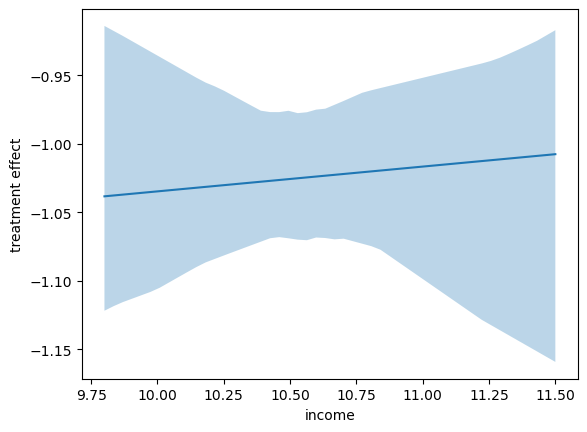

In [57]:
x_avg = oj[sorted(list(covariates))].mean().values
x_income = np.array([np.concatenate([x_avg[:7], [i], x_avg[8:]])  for i in np.linspace(9.8, 11.5, 50)])

treatment_effects_income = est.const_marginal_effect(x_income)
te_lower, te_upper = est.const_marginal_effect_interval(x_income)
plt.plot(x_income[:, 7], treatment_effects_income)
plt.fill_between(x_income[:, 7], te_lower, te_upper, alpha=0.3)
plt.xlabel('income')
plt.ylabel('treatment effect')

### CausalCurve GPS

In [58]:

gps = GPS_Regressor()
gps.fit(T = oj[treatment], X = oj[sorted(list(covariates))], y = oj[outcome])
gps_results = gps.calculate_CDRC(0.95)

The inverse_power link alias is deprecated. Use InversePower instead. The inverse_power link alias will be removed after the 0.15.0 release.


Text(0, 0.5, 'sales of orange juice')

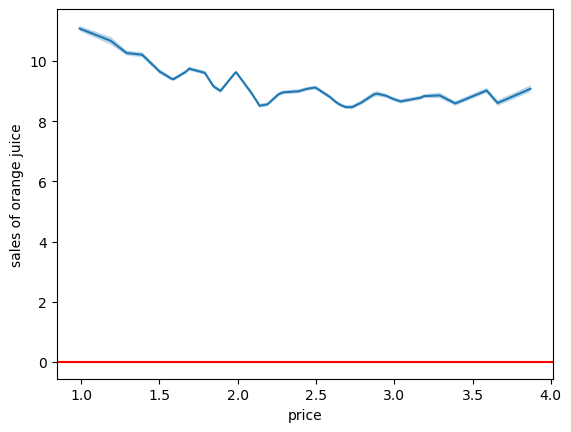

In [59]:
plt.plot(gps_results.Treatment, gps_results.Causal_Dose_Response)
plt.fill_between(gps_results.Treatment, gps_results.Lower_CI, gps_results.Upper_CI, alpha=0.3)
plt.axhline(y=0, color='red')
plt.xlabel('price')
plt.ylabel('sales of orange juice')

### CausalCurve TMLE

Text(0, 0.5, 'medical expenses (log)')

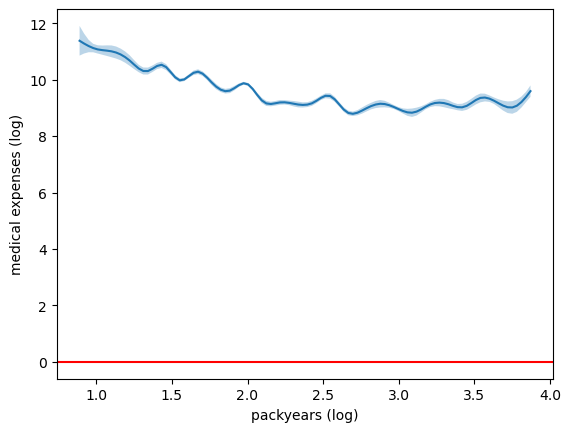

In [60]:

tmle = TMLE_Regressor()
tmle.fit(T = sub_oj[treatment], X = sub_oj[sorted(list(covariates))], y = sub_oj[outcome])
tmle_results = tmle.calculate_CDRC(0.95)
plt.plot(tmle_results.Treatment, tmle_results.Causal_Dose_Response)
plt.fill_between(tmle_results.Treatment, tmle_results.Lower_CI, tmle_results.Upper_CI, alpha=0.3)
plt.axhline(y=0, color='red')
plt.xlabel('packyears (log)')
plt.ylabel('medical expenses (log)')

In [61]:
oj.shape